In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # 1.6.0 버전
# !pip install torch==1.6.0
# !pip install torchvision==0.7.0

In [11]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))
from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu Sep 23 01:24:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   55C    P2   266W / 260W |  43010MiB / 48601MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:1C:00.0 Off |                  Off |
| 43%   

In [12]:
torch.__version__

'1.8.0+cu111'

## Setup imports

In [13]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, NoiseRobustDiceLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    RandScaleIntensityd,
    RandGaussianNoised,
    RandFlipd,
    RandZoomd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandShiftIntensityd,
    SpatialPadd,
    RandAffined,
    CastToTyped,
    DeleteItemsd,
    FgBgToIndicesd,
    Rand3DElasticd,
    RandZoomd,
    Rand2DElasticd,
    RandWeightedCropd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    adaptor,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-154-generic)
Numpy version: 1.18.5
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.54.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [14]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Test

In [15]:
low_imgs      = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/20/*/*/*.npy'))
high_imgs     = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/X/*/*/*.npy'))

dcm_low_imgs  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/20/*/*/*.dcm'))
dcm_high_imgs = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/X/*/*/*.dcm'))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(low_imgs, high_imgs, dcm_low_imgs, dcm_high_imgs)]

print("TEST [Total]  number = ", len(low_imgs))

TEST [Total]  number =  859


## Augmentation

In [16]:
# CT에 맞는 Augmentation
from torchvision import transforms
test_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
#         CenterSpatialCropd(keys=["low", "high"], roi_size=(256, 256)),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [17]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/20/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163914/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_164102_00021.npy
/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/X/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163707/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_163912_00021.npy
image shape: torch.Size([512, 512])


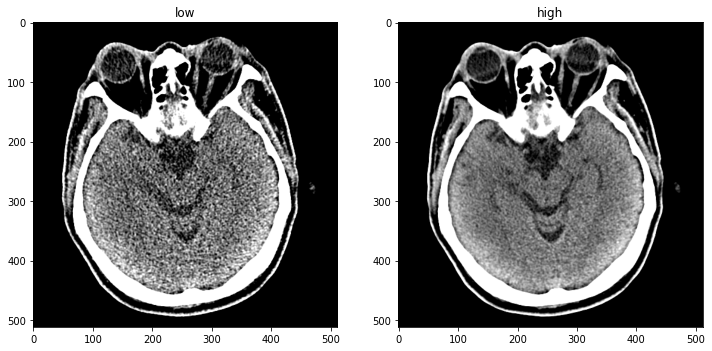

In [18]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[300]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [19]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=12, drop_last=False)

CPU 갯수 =  64


## Create Model, Loss, Optimizer

In [20]:
from SN_CycleGAN_sunggu.model import *
from SN_CycleGAN_sunggu.util import *
import itertools

device = 'cuda'

# 모델
netG_low_2_high = CycleGAN_Generator(in_channels=1, out_channels=1, feature=64, norm='inorm', nblk=9)
netG_high_2_low = CycleGAN_Generator(in_channels=1, out_channels=1, feature=64, norm='inorm', nblk=9)

netD_low  = SN_CycleGAN_Discriminator(in_channels=1, out_channels=1, feature=64, norm='inorm')
netD_high = SN_CycleGAN_Discriminator(in_channels=1, out_channels=1, feature=64, norm='inorm')
    

## 네트워크 불러오기

In [21]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/SN_Cycle_Gan_2D_sinogram/epoch_75_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']

netG_low_2_high.load_state_dict(checkpoint['netG_low_2_high_state_dict'])
netG_high_2_low.load_state_dict(checkpoint['netG_high_2_low_state_dict'])
netD_low.load_state_dict(checkpoint['netD_low_state_dict'])
netD_high.load_state_dict(checkpoint['netD_high_state_dict'])
         

netG_low_2_high.to('cuda')  
netG_high_2_low.to('cuda')  
netD_low.to('cuda')  
netD_high.to('cuda')  


SN_CycleGAN_Discriminator(
  (enc1): SN_CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): SpectralNorm(
        (module): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
      )
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (enc2): SN_CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): SpectralNorm(
        (module): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
      )
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (enc3): SN_CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): SpectralNorm(
        (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
      )
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (enc4): SN_CBR2d(
    (cbr): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): SpectralNorm(
        (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      )
      (2): LeakyReLU(negativ

###### 필요한 Weight만 Load

In [ ]:
# # Before
# model_dict = model.state_dict()
# print("이전 weight = ", model_dict['encoder._conv_stem.weight'][0])

# load_dir = '/workspace/sunggu/1.Hemorrhage/monai_experiment/model/Efficient3d_conv2d_Aux/'
# pretrained_dict =  torch.load(os.path.join(load_dir, "epoch_0_best_metric_model.pth")) 

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model.load_state_dict(model_dict)

# # After
# print("이후 weight = ", model_dict['encoder._conv_stem.weight'][0])

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)

## TEST

In [22]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [23]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [24]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [25]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/Cyclegan_SN_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    netG_low_2_high.eval()
    netG_high_2_low.eval()
    netD_low.eval()
    netD_high.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = netG_low_2_high(input_low)

        # 저장하기
#         print(input_low.min(), input_low.max())
#         input_low[:, 128:128+256, 128:128+256, :] = 0
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        input_high_dcm  = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_high)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_high'][0], input_high_dcm,  test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1])
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        input_high  = fn_denorm_window(fn_tonumpy((input_high)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        input_high  = np.clip(input_high, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_low[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_high[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/859 [00:00<?, ?it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00001.dcm
3954.2097 1.5699291 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00001.dcm
Test:   0%|          | 1/859 [00:00<13:58,  1.02it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00002.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00002.dcm
3933.0664 1.8238955 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/

Test:   2%|▏         | 17/859 [00:02<01:51,  7.54it/s]2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00018.dcm
2675.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00018.dcm
2693.7842 1.6701244 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00018.dcm
2742.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00019.dcm
2739.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00019.dcm
2737.14 1.8251158 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_0001

2690.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00035.dcm
2686.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00035.dcm
2699.8296 1.9305588 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00035.dcm
Test:   4%|▍         | 35/859 [00:03<01:09, 11.80it/s]2664.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00036.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00036.dcm
2675.0745 1.3049792 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00

Test:   6%|▌         | 51/859 [00:05<01:07, 12.03it/s]2562.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00052.dcm
2559.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00052.dcm
2514.074 6.3157187 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00052.dcm
1759.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00053.dcm
1762.0 6.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00053.dcm
1849.6106 11.046252 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_HYE_F39_001_20210521_1545

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00001.dcm
3975.2344 1.8952892 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
Test:   7%|▋         | 57/859 [00:05<01:06, 12.00it/s]3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00002.dcm
3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00002.dcm
3581.1924 1.7826457 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M8

2780.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00017.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00017.dcm
2782.3936 1.7672687 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00017.dcm
Test:   8%|▊         | 73/859 [00:06<01:04, 12.15it/s]2718.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00018.dcm
2709.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00018.dcm
2725.6858 1.7841102 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M8

2531.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00033.dcm
2535.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00033.dcm
2589.3037 1.7396874 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00033.dcm
Test:  10%|█         | 89/859 [00:08<01:04, 12.02it/s]2524.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00034.dcm
2529.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00034.dcm
2574.2437 1.8238955 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M8

2355.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00049.dcm
2351.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00049.dcm
2450.6655 3.3731997 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00049.dcm
Test:  12%|█▏        | 105/859 [00:09<01:03, 11.96it/s]2424.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00050.dcm
2410.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00050.dcm
2536.8289 3.5976322 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M

2607.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00008.dcm
2601.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00008.dcm
2647.9153 2.2608004 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00008.dcm
Test:  14%|█▍        | 121/859 [00:10<01:01, 12.05it/s]2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00009.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00009.dcm
2698.7961 1.8871124 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M

2591.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00024.dcm
2592.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00024.dcm
2642.534 2.0524774 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00024.dcm
Test:  16%|█▌        | 137/859 [00:12<01:01, 11.73it/s]2584.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00025.dcm
2578.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00025.dcm
2639.2693 2.1468146 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M8

2452.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00040.dcm
2453.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00040.dcm
2498.108 2.2655602 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00040.dcm
Test:  18%|█▊        | 153/859 [00:13<00:59, 11.83it/s]2382.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00041.dcm
2390.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00041.dcm
2442.117 2.0843298 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80

988.99994 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00056.dcm
985.99994 7.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00056.dcm
969.4432 9.809616 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00056.dcm
Test:  20%|█▉        | 169/859 [00:14<00:58, 11.80it/s]542.99994 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00057.dcm
539.99994 5.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00057.dcm
694.256 7.961801 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/

Test:  22%|██▏       | 185/859 [00:16<00:56, 11.88it/s]3994.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00016.dcm
3982.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00016.dcm
3785.0415 2.034171 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00016.dcm
2629.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00017.dcm
2630.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00017.dcm
2684.167 1.8564802 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_000

2616.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00033.dcm
2602.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00033.dcm
2653.3018 1.9255552 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00033.dcm
Test:  24%|██▎       | 203/859 [00:17<00:55, 11.85it/s]2576.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00034.dcm
2587.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00034.dcm
2623.358 2.0712714 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00

Test:  25%|██▌       | 219/859 [00:19<00:52, 12.09it/s]2504.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00050.dcm
2485.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00050.dcm
2567.8374 6.890285 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00050.dcm
2492.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00051.dcm
2494.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00051.dcm
2537.3193 6.9359283 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00

Test:  27%|██▋       | 235/859 [00:20<00:51, 12.14it/s]2984.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00009.dcm
2972.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00009.dcm
2997.2996 2.139004 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00009.dcm
2989.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00010.dcm
2968.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00010.dcm
2997.952 1.3999267 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEO_LYE_F65

Test:  29%|██▉       | 251/859 [00:21<00:50, 12.04it/s]2630.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00025.dcm
2629.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00025.dcm
2662.5076 1.5661459 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00025.dcm
2630.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00026.dcm
2628.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00026.dcm
2657.4197 1.6014156 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEO_LYE_F

Test:  31%|███       | 267/859 [00:23<00:49, 12.04it/s]2564.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00041.dcm
2563.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00041.dcm
2567.7576 4.341713 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00041.dcm
2573.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00042.dcm
2570.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00042.dcm
2561.1392 4.3157187 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEO_LYE_F6

Test:  33%|███▎      | 283/859 [00:24<00:47, 12.07it/s]2833.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00004.dcm
2820.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00004.dcm
2842.0583 2.4622893 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00004.dcm
2825.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00005.dcm
2818.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00005.dcm
2845.2847 2.1521845 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_0

2704.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00021.dcm
2693.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00021.dcm
2699.788 2.069563 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00021.dcm
Test:  35%|███▌      | 301/859 [00:26<00:46, 11.99it/s]2703.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00022.dcm
2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00022.dcm
2711.3723 2.1884303 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_000

Test:  37%|███▋      | 317/859 [00:27<00:46, 11.76it/s]2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00038.dcm
2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00038.dcm
2693.0972 2.7495728 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00038.dcm
2647.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00039.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00039.dcm
2647.073 3.0263605 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00

160.99998 11.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00055.dcm
160.99998 16.999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00055.dcm
263.66266 7.2535996 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00055.dcm
Test:  39%|███▉      | 335/859 [00:28<00:43, 12.04it/s]134.99998 12.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00056.dcm
135.99998 17.999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00056.dcm
213.42712 8.762753 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_hig

2879.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00015.dcm
2902.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00015.dcm
2902.521 1.6577983 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00015.dcm
Test:  41%|████      | 351/859 [00:30<00:42, 12.07it/s]2775.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00016.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00016.dcm
2818.0586 1.8099828 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_YON_SOO_F6

2696.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00031.dcm
2687.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00031.dcm
2694.813 1.7224798 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00031.dcm
Test:  43%|████▎     | 367/859 [00:31<00:41, 11.90it/s]2699.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00032.dcm
2696.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00032.dcm
2711.8628 2.0689528 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_YON_SOO_F6

2509.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165016_00047.dcm
2520.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00047.dcm
2527.4424 2.9386134 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165016_00047.dcm
Test:  45%|████▍     | 383/859 [00:32<00:39, 12.00it/s]2523.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165016_00048.dcm
2527.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00048.dcm
2546.8955 6.147547 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHO_YON_SOO_F6

2720.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00008.dcm
2720.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00008.dcm
2744.598 2.1553574 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00008.dcm
Test:  46%|████▋     | 399/859 [00:34<00:38, 11.92it/s]2714.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00009.dcm
2719.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00009.dcm
2725.845 1.6861117 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_000

Test:  48%|████▊     | 415/859 [00:35<00:37, 11.85it/s]2652.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00025.dcm
2658.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00025.dcm
2673.1692 2.328533 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00025.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00026.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00026.dcm
2661.8208 1.8827189 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00

2611.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00042.dcm
2602.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00042.dcm
2635.5059 1.7185745 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00042.dcm
Test:  50%|█████     | 433/859 [00:37<00:35, 12.11it/s]2622.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00043.dcm
2608.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00043.dcm
2651.7603 1.9826701 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_0

Test:  52%|█████▏    | 449/859 [00:38<00:34, 11.93it/s]1064.0 4.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00059.dcm
1057.0 9.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00059.dcm
1142.005 6.684769 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00059.dcm
583.99994 3.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00060.dcm
583.99994 12.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00060.dcm
498.2377 11.046374 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_BYE

Test:  54%|█████▍    | 465/859 [00:39<00:33, 11.93it/s]3009.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00015.dcm
3008.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00015.dcm
2993.0476 2.4290943 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171940_00015.dcm
3019.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00016.dcm
3029.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00016.dcm
3017.1465 3.0226994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUL_YEO_M

Test:  56%|█████▌    | 481/859 [00:41<00:31, 12.04it/s]2672.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00031.dcm
2665.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00031.dcm
2683.5837 2.6732974 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00031.dcm
2670.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00032.dcm
2655.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00032.dcm
2669.8926 2.23505 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUL_YEO_M60

Test:  58%|█████▊    | 497/859 [00:42<00:29, 12.33it/s]2513.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00047.dcm
2498.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00047.dcm
2537.1753 3.5017083 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00047.dcm
2531.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00048.dcm
2529.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00048.dcm
2539.9963 3.127166 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUL_YEO_M6

Test:  60%|█████▉    | 513/859 [00:43<00:28, 12.01it/s]3892.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00063.dcm
3892.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00063.dcm
3916.932 1.5410055 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00063.dcm
2800.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00001.dcm
2808.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00001.dcm
2792.1829 1.9535024 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUN_SEO_F1

Test:  62%|██████▏   | 529/859 [00:45<00:27, 11.95it/s]2767.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00016.dcm
2741.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00016.dcm
2787.433 2.663046 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00016.dcm
2691.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00017.dcm
2696.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00017.dcm
2709.1396 2.286673 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUN_SEO_F18_

Test:  63%|██████▎   | 545/859 [00:46<00:26, 11.68it/s]2650.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00032.dcm
2630.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00032.dcm
2673.5261 1.2916768 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00032.dcm
2645.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00033.dcm
2639.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00033.dcm
2664.382 1.4790089 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUN_SEO_F1

Test:  65%|██████▌   | 561/859 [00:47<00:25, 11.85it/s]2512.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00048.dcm
2497.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00048.dcm
2506.2966 2.79607 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00048.dcm
2521.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00049.dcm
2495.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00049.dcm
2493.7195 3.2610445 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_EUN_SEO_F18

Test:  67%|██████▋   | 577/859 [00:49<00:23, 12.06it/s]2748.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00005.dcm
2732.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00005.dcm
2767.8083 1.4018793 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00005.dcm
2744.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00006.dcm
2748.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00006.dcm
2771.5542 1.4888942 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HEE_JEO_F

Test:  69%|██████▉   | 593/859 [00:50<00:22, 12.00it/s]2626.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00021.dcm
2644.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00021.dcm
2666.4514 1.5030509 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00021.dcm
2658.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00022.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00022.dcm
2688.7246 1.4329996 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HEE_JEO_F

Test:  71%|███████   | 609/859 [00:51<00:20, 11.96it/s]2465.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00037.dcm
2459.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00037.dcm
2491.9402 2.4715643 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173915_00037.dcm
2476.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00038.dcm
2465.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00038.dcm
2507.368 3.3185256 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HEE_JEO_F5

Test:  73%|███████▎  | 625/859 [00:53<00:21, 10.74it/s]977.99994 3.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00053.dcm
988.99994 11.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173731_00053.dcm
1813.9999 7.2157674 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173915_00053.dcm
2861.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174835_00001.dcm
2862.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00001.dcm
2819.3074 2.2898462 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_

Test:  75%|███████▍  | 641/859 [00:54<00:18, 11.59it/s]2941.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00016.dcm
2932.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00016.dcm
2971.0945 1.9155478 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00016.dcm
2867.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00017.dcm
2859.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00017.dcm
2907.534 2.3669758 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HUN_SUK_M4

Test:  76%|███████▋  | 657/859 [00:55<00:16, 12.06it/s]2627.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00032.dcm
2627.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00032.dcm
2681.2385 2.8639247 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00032.dcm
2615.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00033.dcm
2594.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00033.dcm
2647.9143 2.9906027 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HUN_SUK_M

Test:  78%|███████▊  | 673/859 [00:57<00:15, 12.08it/s]2401.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00048.dcm
2401.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00048.dcm
2430.0881 3.1737854 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00048.dcm
2387.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00049.dcm
2375.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00049.dcm
2419.244 4.2427382 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HUN_SUK_M4

Test:  80%|████████  | 689/859 [00:58<00:14, 11.93it/s]3442.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00005.dcm
3430.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00005.dcm
3283.3823 1.6732974 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00005.dcm
2772.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00006.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00006.dcm
2785.2378 1.4781547 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_0

2756.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00022.dcm
2763.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00022.dcm
2796.359 2.401269 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00022.dcm
Test:  82%|████████▏ | 707/859 [01:00<00:13, 11.68it/s]2769.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00023.dcm
2776.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00023.dcm
2791.3474 2.512448 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_0002

Test:  84%|████████▍ | 723/859 [01:01<00:11, 11.95it/s]4087.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00039.dcm
4076.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00039.dcm
3837.6985 2.1819623 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00039.dcm
3426.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00040.dcm
3427.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00040.dcm
3342.8958 2.3447642 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_0

1038.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00056.dcm
1038.0 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00056.dcm
1036.6223 8.567244 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00056.dcm
Test:  86%|████████▋ | 741/859 [01:03<00:09, 11.95it/s]784.99994 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00057.dcm
785.99994 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00057.dcm
804.204 10.321942 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_HWA_M37

2824.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00012.dcm
2835.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00012.dcm
2829.4434 1.7605565 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180811_00012.dcm
Test:  88%|████████▊ | 757/859 [01:04<00:08, 11.98it/s]2781.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00013.dcm
2781.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00013.dcm
2816.7998 1.6288747 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_LYE_HOO_F

2748.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00028.dcm
2747.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00028.dcm
2772.0242 1.5015864 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00028.dcm
Test:  90%|████████▉ | 773/859 [01:05<00:07, 11.99it/s]2772.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00029.dcm
2773.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00029.dcm
2790.8264 1.4570416 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_LYE_HOO_F

2566.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00044.dcm
2566.0 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00044.dcm
2554.2092 3.9029775 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00044.dcm
Test:  92%|█████████▏| 789/859 [01:07<00:05, 11.99it/s]2563.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00045.dcm
2544.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00045.dcm
2548.396 3.8251157 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_LYE

2783.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00005.dcm
2778.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00005.dcm
2832.877 1.8260921 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00005.dcm
Test:  94%|█████████▎| 805/859 [01:08<00:04, 11.95it/s]2826.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00006.dcm
2823.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00006.dcm
2863.199 1.2356602 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_SOO_SEO_F65

2528.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00021.dcm
2527.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00021.dcm
2563.9565 1.6648767 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00021.dcm
Test:  96%|█████████▌| 821/859 [01:09<00:03, 11.80it/s]2543.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00022.dcm
2525.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00022.dcm
2579.516 1.4023675 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_SOO_SEO_F6

2487.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00037.dcm
2494.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00037.dcm
2538.494 1.3633145 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00037.dcm
Test:  97%|█████████▋| 837/859 [01:11<00:01, 12.11it/s]2467.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00038.dcm
2461.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00038.dcm
2510.8909 1.4646082 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_SOO_SEO_F6

2366.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00053.dcm
2359.0 9.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00053.dcm
2468.808 3.6576762 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00053.dcm
Test:  99%|█████████▉| 853/859 [01:12<00:00, 12.00it/s]2217.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00054.dcm
2215.0 9.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00054.dcm
2269.8147 4.3235292 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Cyclegan_SN_epoch_75/low2high/20/pr

## GAN image Metric

### Pred dcm 경로

In [ ]:
# real_dcm_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*50/b40f/*/Brain*B40f_3.0*/*.dcm"))
# real_dcm_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*100/b40f/*/Brain*B40f_3.0*/*.dcm"))

In [16]:
model_dir = "test_SN_cyclegan_2d_epoch_75"
dcm_low_images   = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_low*.dcm"))
dcm_high_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_high*.dcm"))
pred_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/pred*.dcm"))


In [21]:
def CT_12bit_processing(x):
    # H, W, D
    x[x < -1024.0] = -1024.0
    x[x > 3072.0] = 3072.0
    x = (x + 1024.0) / 4095.0
    
    return x

In [18]:
from pydicom import dcmread
import SimpleITK as sitk

gt_tp_list   =[]
pred_tp_list =[]
input_tp_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    np_gt_H    = CT_12bit_processing(np_gt_H)
    np_pred_H  = CT_12bit_processing(np_pred_H)
    np_input_L = CT_12bit_processing(np_input_L)
    
    tp_gt_H   = torch.from_numpy(np_gt_H)
    tp_pred_H = torch.from_numpy(np_pred_H)  # 1, 512, 512
    tp_pred_L = torch.from_numpy(np_input_L)  # 1, 512, 512
    
    gt_tp_list.append(tp_gt_H)
    pred_tp_list.append(tp_pred_H)
    input_tp_list.append(tp_pred_L)
    
gt_zip    = torch.stack(gt_tp_list, dim=0)
pred_zip  = torch.stack(pred_tp_list, dim=0)
input_zip = torch.stack(input_tp_list, dim=0)


449it [00:10, 41.61it/s]


### SSIM

In [ ]:
# x: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).
# y: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).


In [19]:
import piq

prediction  = pred_zip
target      = gt_zip
input       = input_zip

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(prediction, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss = piq.SSIMLoss(data_range=1.0)(prediction, target)
print(f"model SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(input, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss: torch.Tensor = piq.SSIMLoss(data_range=1.0)(input, target)
print(f"Input SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


model SSIM index: 0.9960, loss: 0.0040
Input SSIM index: 0.9974, loss: 0.0026


### PSNR

In [20]:
import piq

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(prediction, target, data_range=1.0, reduction='none')
print(f"model PSNR index: {psnr_index.mean():0.4f}")

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(input, target, data_range=1.0, reduction='none')
print(f"Input PSNR index: {psnr_index.mean():0.4f}")

model PSNR index: 51.0864
Input PSNR index: 56.4575


### 다시 PSNR 수정!

In [ ]:
def cal_PSNR(x):
    peak_pixel = x.max()
    patch_air  = x.squeeze()[30:60, 250:280]
    score = 10*np.log10( peak_pixel ** 2 / np.var(patch_air.flatten()))
    
    return score

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_H_list   =[]
pred_H_list =[]
input_L_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    gt_H_list    = cal_PSNR(np_gt_H)
    pred_H_list  = cal_PSNR(np_pred_H)
    input_L_list = cal_PSNR(np_input_L)


In [ ]:
print(np.mean(gt_H_list))
print(np.mean(pred_H_list))
print(np.mean(input_L_list))

## MSE

In [22]:
import math

def MSE(inputs, target):
    mse  = np.mean( (inputs - target) ** 2 )
    return mse

In [23]:
from pydicom import dcmread
import SimpleITK as sitk

pred_high_mse_list   =[]
input_high_mse_list    =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))

    pred_high_mse    = MSE(np_gt_H, np_pred_H)
    input_high_mse     = MSE(np_gt_H, np_input_L)
    
    pred_high_mse_list.append(pred_high_mse)
    input_high_mse_list.append(input_high_mse)
    
print(f"Model MSE = {np.mean(pred_high_mse_list):0.4f}")
print()
print(f"Input MSE = {np.mean(input_high_mse_list):0.4f}")

449it [00:08, 55.97it/s]

Model MSE = 154.7658

Input MSE = 41.5295


## Difference Map

In [49]:
i = 42
np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_images[i]))
np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_images[i]))
np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(dcm_low_images[i]))

In [50]:
def pure_window(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    return x

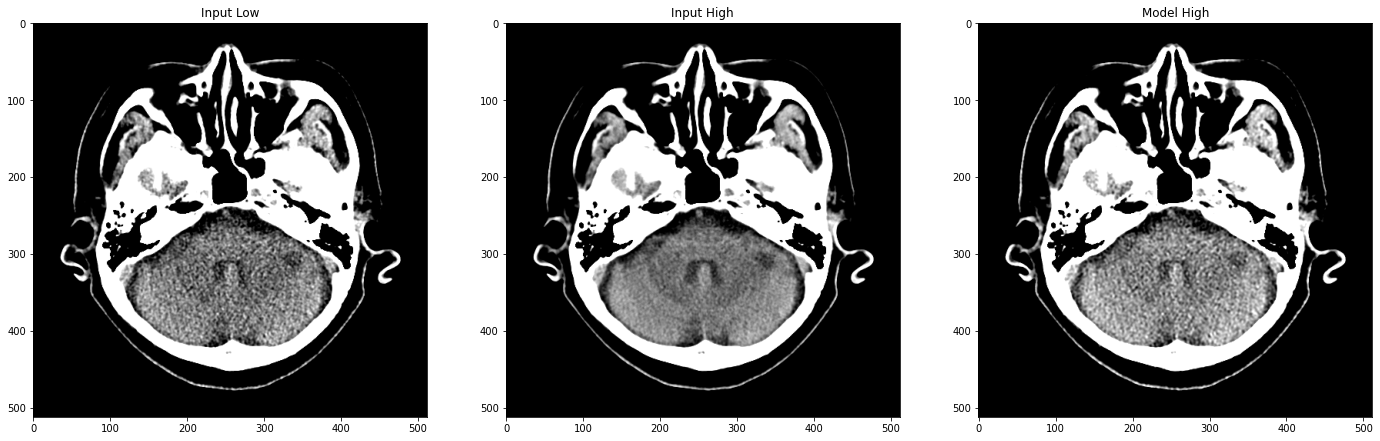

In [51]:
plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("Input Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(132)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Input High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")

plt.subplot(133)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Model High")
plt.imsave('/workspace/sunggu/4.Dose_img2img/model_high_SN.png', pure_window(CT_12bit_processing(np_pred_H[0])),   cmap="gray")

plt.show()

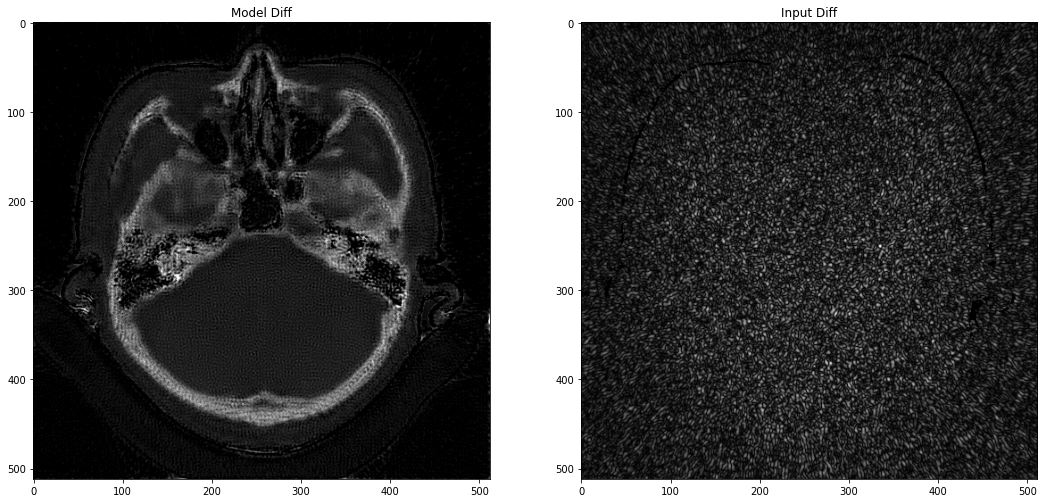

In [73]:
plt.figure(figsize=(18, 12))
plt.subplot(121)
plt.imshow(np.abs(np_pred_H - np_input_L)[0], 'gray')
plt.title("Model Diff")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_diff_SN.png', np.abs(np_pred_H - np_input_L)[0],   cmap="gray")
# t = (np_input_L - np_pred_H)[0]
t = (np_pred_H - np_input_L)[0]
# t = np.abs(np_input_L- np_pred_H)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')

plt.subplot(122)
t = np.abs(np_gt_H - np_input_L)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')
plt.title("Input Diff")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_diff.png', np.abs(np_gt_H - np_input_L)[0],   cmap="gray")

plt.show()

In [56]:
np.abs(np_pred_H - np_input_L)[0].max(), np.abs(np_gt_H - np_pred_H)[0].min(), np.abs(np_gt_H - np_pred_H)[0].mean()

(96, 0, 8.20760726928711)

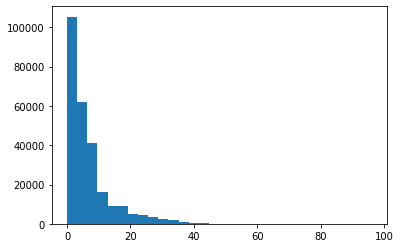

In [57]:
n, bins, patches = plt.hist(np.abs(np_pred_H - np_input_L)[0].flatten(), bins=30)

In [58]:
np.abs(np_gt_H - np_input_L)[0].max(), np.abs(np_gt_H - np_input_L)[0].min(), np.abs(np_gt_H - np_input_L)[0].mean()

(40, 0, 5.165294647216797)

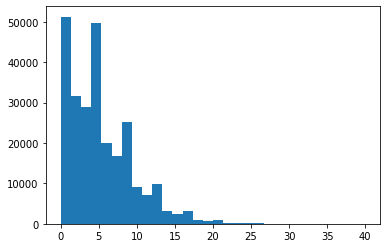

In [59]:
n, bins, patches = plt.hist(np.abs(np_gt_H - np_input_L)[0].flatten(), bins=30)